Digit classification using pre-trained networks like VGGnet-19 for MNIST dataset and analyse and visualize performance improvement. Explore transfer learning using Convolutional Neural Networks (ConvNets) as fixed feature extractors and fine-tuning for image classification. Analyze their performance on a new image classification task while comparing the fixed feature extractor approach with fine-tuning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import VGG19
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input
from keras.optimizers import Adam

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Load a subset of the dataset (5000 training images and 500 testing images)
X_train, y_train = X_train[:5000], y_train[:5000]
X_test, y_test = X_test[:500], y_test[:500]

X_train_froz, X_test_froz = X_train / 255.0, X_test / 255.0
y_train_froz, y_test_froz = to_categorical(y_train), to_categorical(y_test)

In [5]:
# Fixed feature extractor approach
model_frozen = Sequential([
Flatten(input_shape=X_train.shape[1:]),
Dense(256, activation='relu'),
Dense(10, activation='softmax')
])

model_frozen.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Training the frozen model
history_frozen = model_frozen.fit(X_train_froz, y_train_froz, epochs=5, 
                                  batch_size=32, validation_data=(X_test_froz, y_test_froz))

Epoch 1/5
157/157 [==============================] - 1s 5ms/step - loss: 0.5990 - accuracy: 0.8360 - val_loss: 0.3684 - val_accuracy: 0.8940
Epoch 2/5
157/157 [==============================] - 1s 4ms/step - loss: 0.2550 - accuracy: 0.9314 - val_loss: 0.3260 - val_accuracy: 0.8960
Epoch 3/5
157/157 [==============================] - 1s 4ms/step - loss: 0.1792 - accuracy: 0.9512 - val_loss: 0.2360 - val_accuracy: 0.9300
Epoch 4/5
157/157 [==============================] - 1s 4ms/step - loss: 0.1277 - accuracy: 0.9670 - val_loss: 0.1961 - val_accuracy: 0.9340
Epoch 5/5
157/157 [==============================] - 1s 4ms/step - loss: 0.0953 - accuracy: 0.9764 - val_loss: 0.1868 - val_accuracy: 0.9480


In [3]:
# Convert grayscale images to RGB (VGG requires 3 channels)
X_train_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(X_train, axis=-1))
X_test_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(X_test, axis=-1))

# Resize images to match VGG input size (224x224)
X_train_resized = tf.image.resize(X_train_rgb, (224, 224))
X_test_resized = tf.image.resize(X_test_rgb, (224, 224))

# Normalize pixel values to [0, 1]
X_train_resized = X_train_resized / 255.0
X_test_resized = X_test_resized / 255.0

# Convert labels to one-hot encoding
y_train_rgb = to_categorical(y_train, num_classes=10)
y_test_rgb = to_categorical(y_test, num_classes=10)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_finetuned = Model(inputs=base_model.input, outputs=output) # Create the fine-tuned model

# Freeze the layers of the base VGG model
for layer in base_model.layers:
    layer.trainable = False

model_finetuned.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Train the model
history_finetuned = model_finetuned.fit(X_train_resized, y_train_rgb, batch_size=64, 
                                        epochs=5, validation_data=(X_test_resized, y_test_rgb))

# Evaluate the model
loss, accuracy = model_finetuned.evaluate(X_test_resized, y_test_rgb)
print("Test accuracy:", accuracy)

Epoch 1/5
79/79 [==============================] - 65s 615ms/step - loss: 0.7217 - accuracy: 0.8530 - val_loss: 0.0793 - val_accuracy: 0.9780
Epoch 2/5
79/79 [==============================] - 30s 381ms/step - loss: 0.0643 - accuracy: 0.9836 - val_loss: 0.0819 - val_accuracy: 0.9740
Epoch 3/5
79/79 [==============================] - 28s 356ms/step - loss: 0.0446 - accuracy: 0.9890 - val_loss: 0.0444 - val_accuracy: 0.9880
Epoch 4/5
79/79 [==============================] - 28s 354ms/step - loss: 0.0234 - accuracy: 0.9948 - val_loss: 0.0527 - val_accuracy: 0.9800
Epoch 5/5
16/16 [==============================] - 12s 402ms/step - loss: 0.0589 - accuracy: 0.9840
Test accuracy: 0.984000027179718


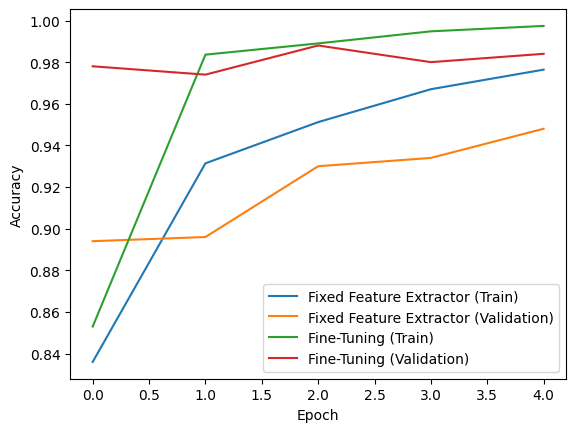

In [6]:
plt.plot(history_frozen.history['accuracy'], label='Fixed Feature Extractor (Train)')
plt.plot(history_frozen.history['val_accuracy'], label='Fixed Feature Extractor (Validation)')
plt.plot(history_finetuned.history['accuracy'], label='Fine-Tuning (Train)')
plt.plot(history_finetuned.history['val_accuracy'], label='Fine-Tuning (Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()